<a href="https://colab.research.google.com/github/Negus25/Demo/blob/main/chapter_convolutional-neural-networks/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [7]:
!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 83 kB 1.5 MB/s 
     |███████████████████████████████▌| 834.1 MB 1.3 MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x55e3632c0000 @  0x7f8b61d53615 0x55e32a15e02c 0x55e32a23e17a 0x55e32a160e4d 0x55e32a252c0d 0x55e32a1d50d8 0x55e32a1cfc35 0x55e32a16273a 0x55e32a1d4f40 0x55e32a1cfc35 0x55e32a16273a 0x55e32a1d193b 0x55e32a253a56 0x55e32a1d0fb3 0x55e32a253a56 0x55e32a1d0fb3 0x55e32a253a56 0x55e32a1d0fb3 0x55e32a162b99 0x55e32a1a5e79 0x55e32a1617b2 0x55e32a1d4e65 0x55e32a1cfc35 0x55e32a16273a 0x55e32a1d193b 0x55e32a1cfc35 0x55e32a16273a 0x55e32a1d0b0e 0x55e32a16265a 0x55e32a1d0d67 0x55e32a1cfc35
     |████████████████████████████████| 846.0 MB 22 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Convolutional Neural Networks (LeNet)
:label:`sec_lenet`

We now have all the ingredients required to assemble
a fully-functional CNN.
In our earlier encounter with image data,
we applied
a softmax regression model (:numref:`sec_softmax_scratch`)
and
an MLP model (:numref:`sec_mlp_scratch`)
to pictures of clothing in the Fashion-MNIST dataset.
To make such data amenable to softmax regression and MLPs,
we first flattened each image from a $28\times28$ matrix
into a fixed-length $784$-dimensional vector,
and thereafter processed them with fully-connected layers.
Now that we have a handle on convolutional layers,
we can retain the spatial structure in our images.
As an additional benefit of replacing fully-connected layers with convolutional layers,
we will enjoy more parsimonious models that require far fewer parameters.

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images :cite:`LeCun.Bottou.Bengio.ea.1998`.
This work represented the culmination
of a decade of research developing the technology.
In 1989, LeCun published the first study to successfully
train CNNs via backpropagation.


At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann and his colleague Leon Bottou wrote in the 1990s!


## LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully-connected layers**);
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
these discoveries had not yet been made in the 1990s.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully-connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully-connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
hopefully the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers.


In [8]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    # `Dense` will transform an input of the shape (batch size, number of
    # channels, height, width) into an input of the shape (batch size,
    # number of channels * height * width) automatically by default
    nn.Dense(120, activation='sigmoid'), nn.Dense(84, activation='sigmoid'),
    nn.Dense(10))

We took a small liberty with the original model,
removing the Gaussian activation in the final layer.
Other than that, this network matches
the original LeNet-5 architecture.

By passing a single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to make sure
that its operations line up with
what we expect from :numref:`img_lenet_vert`.

![Compressed notation for LeNet-5.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/lenet-vert.svg?raw=1)
:label:`img_lenet_vert`


In [9]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 6, 28, 28)
pool0 output shape:	 (1, 6, 14, 14)
conv1 output shape:	 (1, 16, 10, 10)
pool1 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


Note that the height and width of the representation
at each layer throughout the convolutional block
is reduced (compared with the previous layer).
The first convolutional layer uses 2 pixels of padding
to compensate for the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.
In contrast, the second convolutional layer forgoes padding,
and thus the height and width are both reduced by 4 pixels.
As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second convolutional layer.
However, each pooling layer halves the height and width.
Finally, each fully-connected layer reduces dimensionality,
finally emitting an output whose dimension
matches the number of classes.



## Training

Now that we have implemented the model,
let us [**run an experiment to see how LeNet fares on Fashion-MNIST**].


In [13]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

While CNNs have fewer parameters,
they can still be more expensive to compute
than similarly deep MLPs
because each parameter participates in many more
multiplications.
If you have access to a GPU, this might be a good time
to put it into action to speed up training.


For evaluation, we need to [**make a slight modification
to the `evaluate_accuracy` function**] that we described
in :numref:`sec_softmax_scratch`.
Since the full dataset is in the main memory,
we need to copy it to the GPU memory before the model uses GPU to compute with the dataset.


In [15]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if not device:  # Query the first device where the first parameter is on
        device = list(net.collect_params().values())[0].list_ctx()[0]
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

We also need to [**update our training function to deal with GPUs.**]
Unlike the `train_epoch_ch3` defined in :numref:`sec_softmax_scratch`,
we now need to move each minibatch of data
to our designated device (hopefully, the GPU)
prior to making the forward and backward propagations.

The training function `train_ch6` is also similar
to `train_ch3` defined in :numref:`sec_softmax_scratch`.
Since we will be implementing networks with many layers
going forward, we will rely primarily on high-level APIs.
The following training function assumes a model created from high-level APIs
as input and is optimized accordingly.
We initialize the model parameters
on the device indicated by the `device` argument, using Xavier initialization as introduced in :numref:`subsec_xavier`.
Just as with MLPs, our loss function is cross-entropy,
and we minimize it via minibatch stochastic gradient descent.
Since each epoch takes tens of seconds to run,
we visualize the training loss more frequently.


In [16]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the major difference from `d2l.train_epoch_ch3`
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

[**Now let us train and evaluate the LeNet-5 model.**]


loss 0.472, train acc 0.822, test acc 0.808
11257.7 examples/sec on gpu(0)


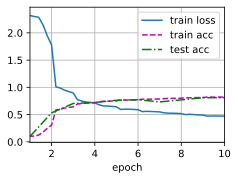

In [17]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary

* A CNN is a network that employs convolutional layers.
* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.
* In a CNN, convolutional layers are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.
* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output.
* LeNet was arguably the first successful deployment of such a network.

## Exercises

1. Replace the average pooling with maximum pooling. What happens?
1. Try to construct a more complex network based on LeNet to improve its accuracy.
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the activation function (e.g., ReLU).
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs.)
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).


[Discussions](https://discuss.d2l.ai/t/73)
